# Train a deep CNN on XPS data on Google Colab

In this notebook, we will train a deep convolutional network on iron XPS spectra using the local CPU/GPU.

## Setup

### Mount google drive, change working directory

In [3]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Change working path
os.chdir('/content/drive/My Drive/app')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Install packages and import modules

In [5]:
# Install packages
!pip install python-docx

# Import standard modules and magic commands
import datetime
import numpy as np
import pytz
import importlib

# Magic commands
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

     |████████████████████████████████| 5.5MB 5.6MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.10-cp36-none-any.whl size=184491 sha256=59b80d15ca0c27dbcce2f13a83c06a71faaaba56621c63f7ea0bd362e5f49f8b
  Stored in directory: /root/.cache/pip/wheels/18/0b/a0/1dd62ff812c857c9e487f27d80d53d2b40531bec1acecfa47b
Successfully built python-docx


### Load custom modules

In [29]:
try:
    import importlib
    importlib.reload(classifier)
    importlib.reload(clfutils)
    print('Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.utils as clfutils
    print('Modules were loaded.')

<module 'xpsdeeplearning.network.classifier' from '/content/drive/My Drive/app/xpsdeeplearning/network/classifier.py'>

Modules were loaded.


## Classification

### Setting up the parameters & folder structure

In [ ]:
np.random.seed(502)
time =  datetime.datetime.now().astimezone(pytz.timezone('Europe/Berlin')).strftime("%Y%m%d_%Hh%Mm")
data_name = 'Fe_single_4_classes'

label_values = ['Fe metal', 'FeO', 'Fe3O4', 'Fe2O3']

clf = classifier.ClassifierSingle(time = time,
                                  data_name = data_name,
                                  labels = label_values)

Model folder created at /saved_models/20200629_23h27m_Fe_single_4_classes
Logs folder created at /logs/20200629_23h27m_Fe_single_4_classes
Figures folder created at /figures/20200629_23h27m_Fe_single_4_classes


### Load and inspect the data

Data was loaded!
Total no. of samples: 100000
No. of training samples: 64000
No. of validation samples: 16000
No. of test samples: 20000
Shape of each sample : 1121 features (X) + 4 labels (y)


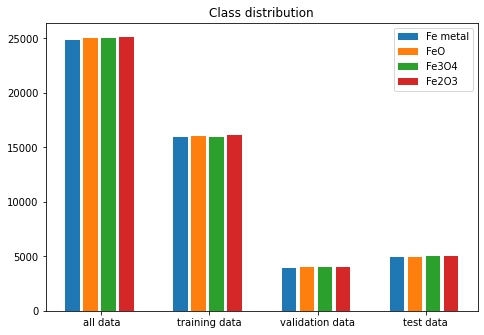

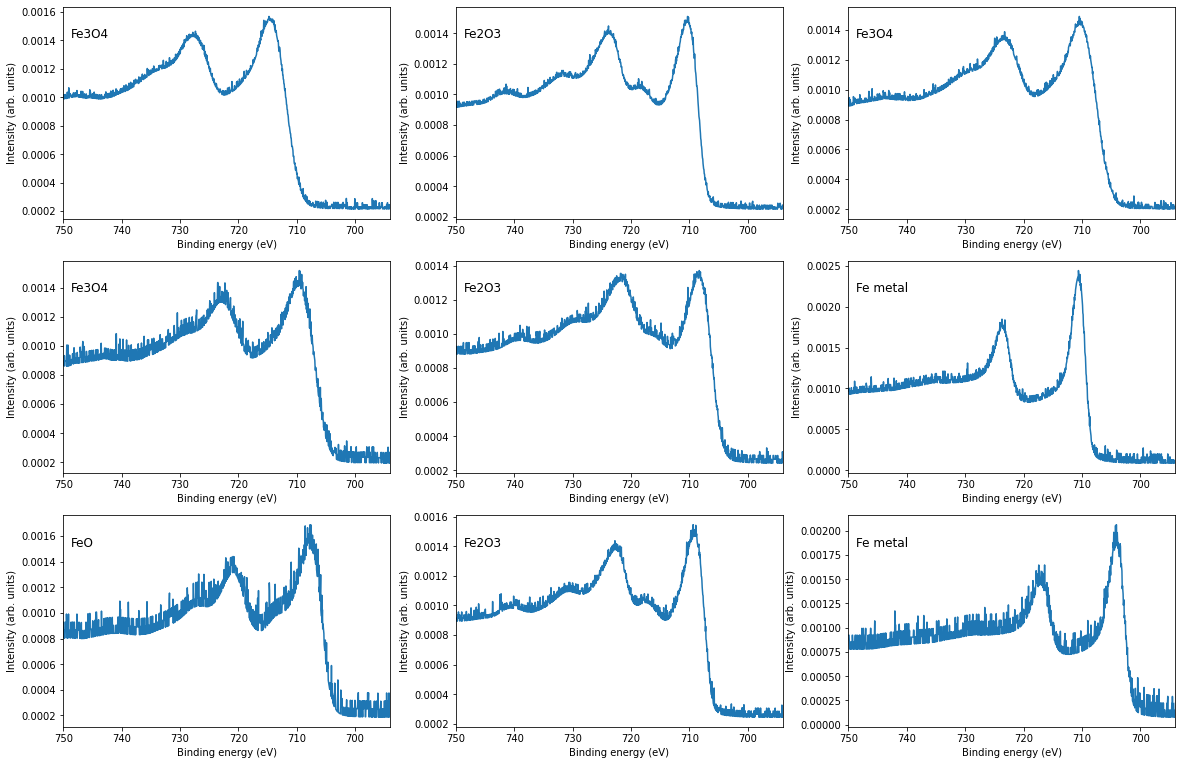

In [ ]:
input_filepath = r'/content/drive/My Drive/app/datasets/20200605_iron_single_small.h5'
train_test_split = 0.2
train_val_split = 0.2
no_of_examples = 100000

X_train, X_val, X_test, y_train, y_val, y_test = \
        clf.load_data_preprocess(input_filepath = input_filepath,
                                 no_of_examples = no_of_examples,
                                 train_test_split = train_test_split,
                                 train_val_split = train_val_split)
        
# Check how the examples are distributed across the classes.
class_distribution = clf.check_class_distribution()
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 9, dataset = 'train')  

### Design the model

In [6]:
try:
    importlib.reload(models)
    print('Models module was reloaded.')
except:
    import xpsdeeplearning.network.models as models
    print('Models module was loaded.')

Models module was loaded.


In [7]:
from tensorflow.keras.layers import Input, Dense, Flatten, concatenate
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AveragePooling1D, MaxPooling1D
#from tensorflow.keras.layers import BatchNormalization

class CustomCNNSub(models.EmptyModel):
    def __init__(self, inputshape, num_classes):      
        input_1 = Input(shape = inputshape)
                
        conv_1_short = Conv1D(4, 5, padding = 'same',
                            activation = 'relu')(input_1)
        conv_1_medium = Conv1D(4, 10, padding = 'same',
                             activation = 'relu')(input_1)
        conv_1_long = Conv1D(4, 15, padding = 'same',
                           activation = 'relu')(input_1)
        sublayers = [conv_1_short, conv_1_medium, conv_1_long]
        merged_sublayers = concatenate(sublayers)
        
        conv_2 = Conv1D(4, 5, activation='relu')(merged_sublayers)
        average_pool_1 = AveragePooling1D()(conv_2)
        
        flatten_1 = Flatten()(average_pool_1)
        drop_1 = Dropout(0.2)(flatten_1)
        dense_1 = Dense(2000, activation = 'relu')(drop_1)
        
        dense_2 = Dense(num_classes, activation = 'softmax')(dense_1)
        
        no_of_inputs = len(sublayers)

        super(CustomCNNSub, self).__init__(inputs = input_1,
                                           outputs = dense_2,
                                           inputshape = inputshape,
                                           num_classes = num_classes,
                                           no_of_inputs = no_of_inputs, 
                                           name = 'Custom_CNN_Sub')

In [ ]:
input_shape = (1121,1)
num_classes = 4
model = CustomCNNSub(input_shape, num_classes)

import os
filepath = os.getcwd()


model.save(filepath)
inputs = {'model': model.no_of_inputs}
inputs['model_config'] = model.get_config()['no_of_inputs']
 
custom_objects = {'EmptyModel' : models.EmptyModel}
custom_objects[str(type(model).__name__)] = type(model).__name__
print(custom_objects)

from tensorflow.keras.models import load_model
 
loaded_model = load_model(filepath, custom_objects = custom_objects)
loaded_model.summary()
#inputs['loaded_model_config'] = loaded_model.get_config()['no_of_inputs']
loaded_model.get_config() 
#     no_of_drop_layers = 2
#     new_model = EmptyModel(
#         inputs = loaded_model.input,
#         outputs = loaded_model.layers[-no_of_drop_layers].output,
#         inputshape = input_shape,
#         num_classes = num_classes,
#         no_of_inputs = loaded_model.get_config()['no_of_inputs'],
#         name = 'Changed_Model')
#     new_model.summary()
#     inputs['new_model'] = new_model.no_of_inputs
#     inputs['new_model_config'] = new_model.get_config()['no_of_inputs']

### Build the model

In [ ]:
clf.model = CustomCNNSub(clf.input_shape, clf.num_classes)

# Alternative: Build model from available models
#clf.model = models.CustomCNNSub(clf.input_shape, clf.num_classes)

### Compile and summarize the model

Model: "Custom_CNN_Sub"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1121, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 1121, 4)      24          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 1121, 4)      44          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 1121, 4)      64          input_2[0][0]                    
_____________________________________________________________________________________

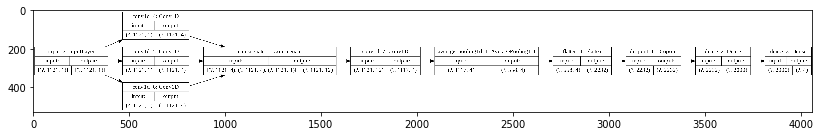

In [ ]:
from tensorflow.keras.optimizers import Adam
learning_rate = 1e-05
optimizer = Adam(learning_rate = learning_rate) 


def custom_loss(y_true, y_pred):
    """
    Custom loss for linear combination of XPS spectra.
    """
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

#clf.model.compile(loss = custom_loss, optimizer = 'adam', )


# Alternative: Compile model with build-in loss function
clf.model.compile(loss = 'categorical_crossentropy',
                  optimizer = optimizer, 
                  metrics = ['accuracy'])


# Plot summary and save model plot.
clf.summary()
clf.save_and_print_model_image()

### Training

In [ ]:
epochs = 150
batch_size = 32

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 epochs = epochs, 
                 batch_size = batch_size,
                 verbose = 1)

Epoch 1/150
1999/2000 [============================>.] - ETA: 0s - loss: 1.3755 - accuracy: 0.3722WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/app/saved_models/20200629_23h27m_Fe_single_4_classes/assets
2000/2000 [==============================] - 10s 5ms/step - loss: 1.3755 - accuracy: 0.3723 - val_loss: 1.3564 - val_accuracy: 0.4009
Epoch 2/150
2000/2000 [==============================] - 10s 5ms/step - loss: 1.3216 - accuracy: 0.3986 - val_loss: 1.2868 - val_accuracy: 0.3964
Epoch 3/150
2000/2000 [==============================] - 10s 5ms/step - loss: 1.2500 - accuracy: 0.4219 - val_loss: 1.2171 - val_accuracy: 0.4445


### Graphs

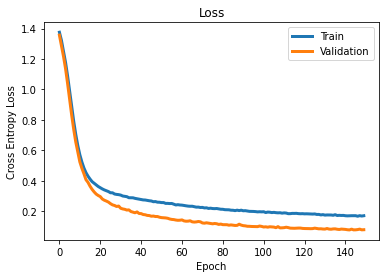

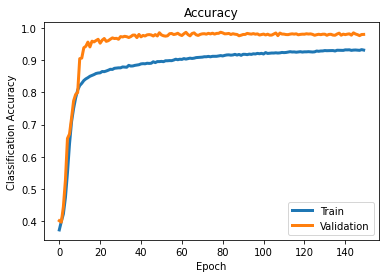

In [ ]:
dir_name = clf.time + '_' + clf.data_name
graph = clfutils.TrainingGraphs(clf.history, dir_name)
graph.plot_loss()
graph.plot_accuracy()

### Evaluation on test data

In [ ]:
score = clf.evaluate()
test_loss, test_accuracy = score[0], score[1]
print('Test loss: ' + str(np.round(test_loss, decimals=3)))
print('Test accuracy: ' + str(np.round(test_accuracy, decimals=3)))

625/625 [==============================] - 1s 2ms/step - loss: 0.0776 - accuracy: 0.9814
Evaluation done! 

Test loss: 0.078
Test accuracy: 0.981


###  Prediction on test data

In [ ]:
pred_train, pred_test = clf.predict()
pred_train_classes, pred_test_classes = clf.predict_classes()

625/625 [==============================] - 1s 2ms/step
Prediction done!
Class prediction done!


### Show some predictions

#### 5 random training samples

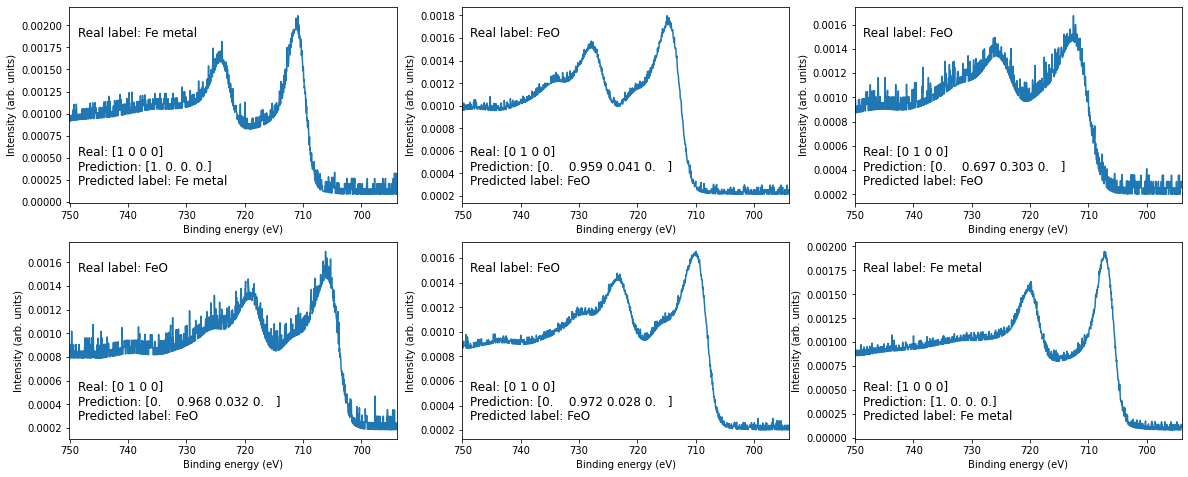

In [ ]:
clf.plot_random(no_of_spectra = 6, dataset = 'train', with_prediction = True)  

#### 5 random test samples

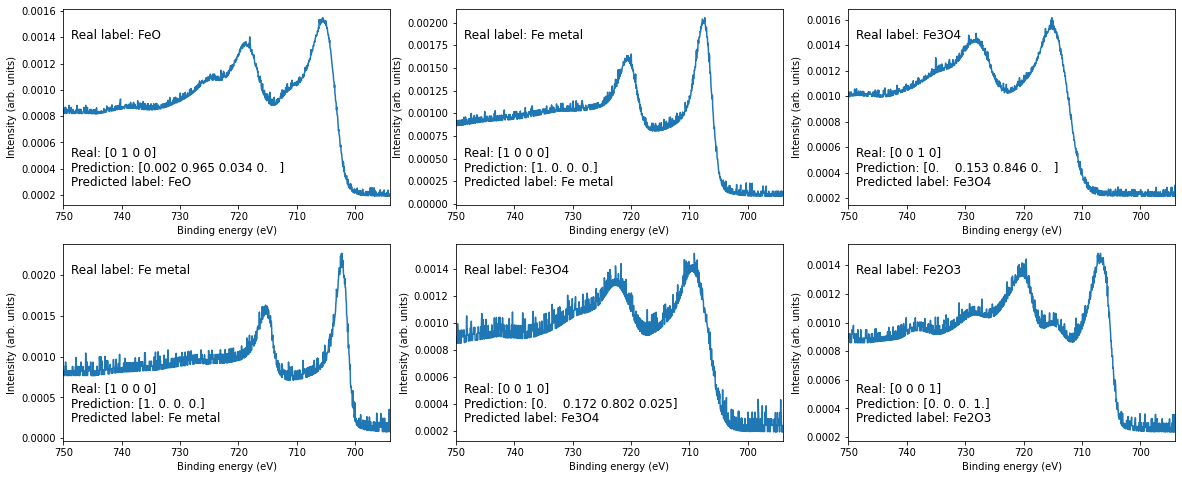

In [ ]:
clf.plot_random(no_of_spectra = 6, dataset = 'test', with_prediction = True)  

### Show wrong predictions

In [ ]:
clf.show_wrong_classification()

No. of wrong predictions on the test data: 0


### Saving model and data

In [ ]:
clf.save_model()
clf.save_hyperparams()
clf.shelve_results(full = False)

INFO:tensorflow:Assets written to: /content/drive/My Drive/app/saved_models/20200629_23h27m_Fe_single_4_classes/assets
Saved model to disk.
Saved hyperparameters to file.
Saved results to file.


### Report

In [ ]:
dir_name = clf.time + '_' + clf.data_name
rep = clfutils.Report(dir_name)  
rep.write()   

Report saved!


### Save output of notebook

In [ ]:
from IPython.display import Javascript, display
from nbconvert import HTMLExporter

def save_notebook():
    display(Javascript("IPython.notebook.save_notebook()"),
            include=['application/javascript'])

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

import time
import os

save_notebook()
time.sleep(10)
current_file = '/content/drive/My Drive/app/xpsdeeplearning/train_colab_single.ipynb'
output_file = os.path.join(clf.log_dir,'train_colab_out.html')
output_HTML(current_file, output_file)